In [1]:
import control_utils
import controllers
import polytope
import numpy as np
import matplotlib.pyplot as plt
import trajectory_optimizers
import tqdm
import uncertainty_utils

## Setup Experiments

In [2]:
# Dynamics
A_true = np.array([[1,.2],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
n = A_true.shape[0]
m = B_true.shape[1]
C_true = np.zeros(n)
x_init = np.array([2.7, 2])
state_limits = polytope.box2poly([[-4, 4],[-3, 3]])
input_limits = polytope.box2poly([[-2, 2]])

# LQR Cost:
Q = np.eye(n)
R = np.eye(m)

# Noise and Disturbances
process_noise_var = 1e-3
process_noise = process_noise_var * np.eye(n)
t = uncertainty_utils.calc_t(0.95, n)
disturbance_set = uncertainty_utils.get_elipse(t, process_noise, np.zeros(n))
db = t * np.sqrt(process_noise_var)
disturbance_bound = polytope.box2poly([[-db, db],[-db, db]])

# Experiment Details
episode_length = 20
controller_horizon = 3
state_reference = np.zeros(n)
state_constraints = (state_limits.A, state_limits.b)
input_constraints = (input_limits.A, input_limits.b)

def sim_traj(A, B, controller, x_init, N=episode_length, process_noise=np.zeros((n,n)), input_limits=np.array([-1e9, 1e9])):
    x_traj = [x_init]
    u_traj = []
    
    x_pred_trajs = []
    u_pred_trajs = []

    for _ in tqdm.tqdm(range(N)):
        u_command = controller.solve(x_traj[-1])
        if u_command is None:
            print("controller error at iteration %d" %_)
            break
        u = np.minimum(np.maximum(input_limits[0], u_command), input_limits[1])
        x_next = A @ x_traj[-1] + B @ u + np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise)

        x_traj.append(x_next)
        u_traj.append(u)
        
        if hasattr(controller, "x_traj"):
            x_pred_trajs.append(controller.x_traj.value.T)
            u_pred_trajs.append(controller.u_traj.value.T)

    return np.array(x_traj), np.array(u_traj), x_pred_trajs, u_pred_trajs

## Visualize Disturbance Sets

Text(0.5,1,'Disturbance Set')

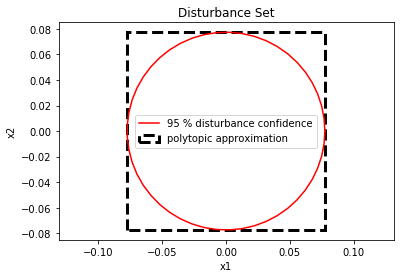

In [3]:
plt.figure()
ax = plt.gca()
plt.axis("equal")
plt.plot(disturbance_set[:,0], disturbance_set[:,1], color="r")
disturbance_bound.plot(ax=ax, alpha=1, color="w", edgecolor="k")
plt.legend(("95 % disturbance confidence", "polytopic approximation"))
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Disturbance Set")

## Tracking MPC

In [4]:
controller = controllers.LTI_MPC_Tracker(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [5]:
x_init_traj, u_init_traj, x_init_preds, u_init_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
init_value_function = control_utils.compute_traj_cost(x_init_traj[:-1,:].T, u_init_traj.T, h)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.81it/s]


(-3, 3)

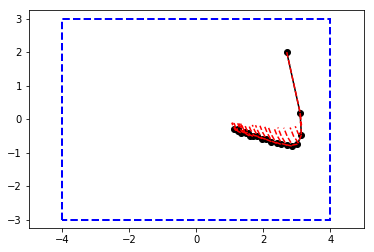

In [6]:
alpha = 1
lw = 2
xlims = (-5,5)
ylims = (-3,3)

plt.figure()
plt.axis("equal")
ax = plt.gca()

plt.plot(x_init_traj[:,0], x_init_traj[:,1], "k-o")
for x_pred in x_init_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## MPC

In [7]:
controller = controllers.LTI_MPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()

In [18]:
x_mpc_traj, u_mpc_traj, x_mpc_preds, u_mpc_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.99it/s]


(-3, 3)

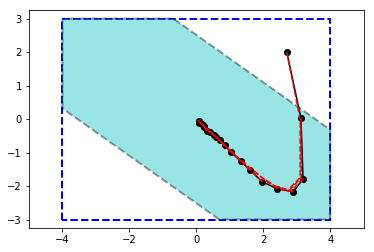

In [19]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

plt.plot(x_mpc_traj[:,0], x_mpc_traj[:,1], "k-o")
for x_pred in x_mpc_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")

X_terminal = polytope.Polytope(*controller.terminal_constraint)
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)
X_terminal.plot(ax=ax, alpha=.4, color="c", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## Tube MPC

In [20]:
controller = controllers.LTI_Tube_MPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build((disturbance_bound.A, disturbance_bound.b))

In [21]:
x_tube_traj, u_tube_traj, x_tube_preds, u_tube_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.23it/s]


(-3, 3)

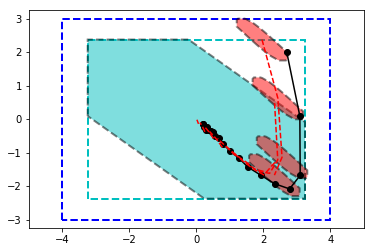

In [22]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=1, color="w", edgecolor="b", linewidth=lw)
X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

plt.plot(x_tube_traj[:,0], x_tube_traj[:,1], "k-o")
for x_pred in x_tube_preds:
    plt.plot(x_pred[:,0], x_pred[:,1], "r--")

X_terminal = polytope.Polytope(*controller.terminal_constraint)
M = polytope.Polytope(*controller.init_constraint)

X_terminal.plot(ax=ax, alpha=0.5, color="c", linewidth=lw)

for x in np.rollaxis(x_tube_preds[0], 0):
    Mx = control_utils.poly_translate(M, x)
    Mx.plot(ax=ax, alpha=.5, color="r", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

## Learning MPC

In [23]:
num_episodes = 10
controller = controllers.LTI_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
value_function = control_utils.compute_traj_cost(x_mpc_traj[:-1,:].T, u_mpc_traj.T, h)
controller.add_trajectory(x_mpc_traj[:-1,:].T, u_mpc_traj.T, value_function)

In [24]:
for episode in range(num_episodes):
#     print(episode)
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init)
    value_function = control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h)
    controller.add_trajectory(x_traj[:-1,:].T, u_traj.T, value_function)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.07it/s]


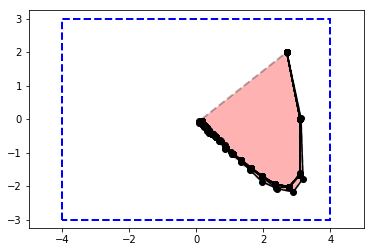

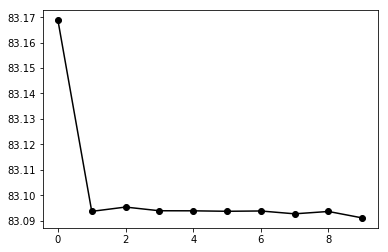

In [25]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")

SS = polytope.qhull(controller.safe_set.value.T)
state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)

plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")

## Tube LMPC

In [26]:
num_episodes = 5
w = (disturbance_bound.A, disturbance_bound.b)
controller = controllers.LTI_Tube_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints, w)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_mpc_traj.T, u_mpc_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [27]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.83it/s]


(10, 2)
(35, 2)


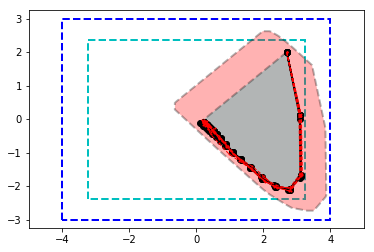

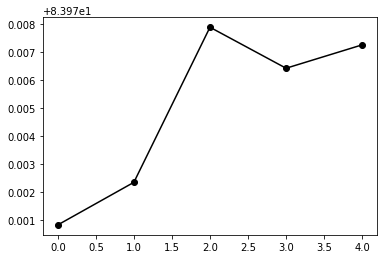

In [28]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
M = polytope.Polytope(*controller.init_constraint)
RSS = control_utils.minkowski_sum(SS, M)
print(SS.A.shape)
print(M.A.shape)
RSS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    

for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=1, markersize=1)
    
plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
# plt.plot([q[0] for q in true_costs], "ro-")

## Robust LMPC

In [29]:
num_episodes = 5
w = (disturbance_bound.A, disturbance_bound.b)
controller = controllers.LTI_Robust_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints, w)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_mpc_traj.T, u_mpc_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [30]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.13it/s]


(10, 2)
(35, 2)


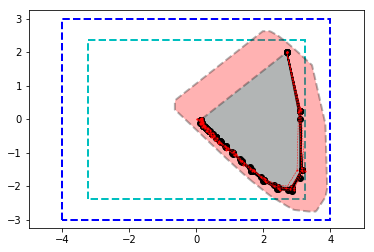

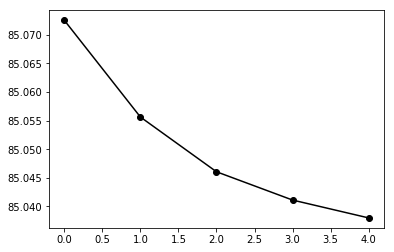

In [31]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
M = polytope.Polytope(*controller.minimal_invariant)
print(SS.A.shape)
print(M.A.shape)
RSS = control_utils.minkowski_sum(SS, M)

RSS.plot(ax=ax, alpha=0.3, color="r", linewidth=lw)
SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    
for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=.5, markersize=1)
    
plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[1:]], "ko-")
# plt.plot([q[0] for q in true_costs], "ro-")
# plt.ylim((82,86))

## Robust Stochastic LMPC

In [32]:
num_episodes = 5
Sigma = process_noise * t ** 2
controller = controllers.LTI_Stochastic_LMPC(A_true, B_true, C_true,
                                         controller_horizon, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints, Sigma)
h = lambda x, u: x.T @ Q @ x + u.T @ R @ u
x_nominal, u_nominal = control_utils.compute_nominal_traj(x_tube_traj.T, u_tube_traj.T, A_true, B_true, C_true, controller.K)
value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)

In [33]:
true_costs = []
true_trajs = []
for episode in range(num_episodes):
    x_traj, u_traj, x_preds, u_preds = sim_traj(A_true, B_true, controller, x_init, process_noise=process_noise)
    x_nominal, u_nominal = control_utils.compute_nominal_traj(x_traj.T, u_traj.T, A_true, B_true, C_true, controller.K)
    value_function = control_utils.compute_traj_cost(x_nominal[:,:-1], u_nominal, h)
    true_costs.append(control_utils.compute_traj_cost(x_traj[:-1,:].T, u_traj.T, h))
    controller.add_trajectory(x_nominal[:,:-1], u_nominal, value_function)
    true_trajs.append(x_traj)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.38it/s]


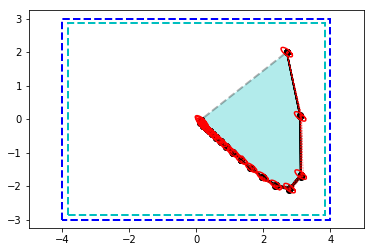

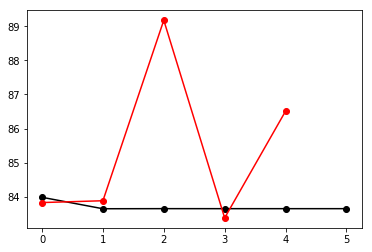

In [34]:
plt.figure()
plt.axis("equal")
ax = plt.gca()

state_limits.plot(ax=ax, alpha=alpha, color="w", edgecolor="b", linewidth=lw)

X_bar = polytope.Polytope(*controller.state_constraints)
X_bar.plot(ax=ax, alpha=1, color="w", linewidth=lw, edgecolor="c")

SS = polytope.qhull(controller.safe_set.value.T)
# M = polytope.Polytope(*controller.minimal_invariant)

SS.plot(ax=ax, alpha=0.3, color="c", linewidth=lw)
for x_traj in controller.traj_list:
    plt.plot(x_traj[0,:], x_traj[1,:], "k-o")
    
for x_traj in true_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "r--o", lw=.5, markersize=1)

terminal_cov = controller.minimal_invariant_covariance / (t ** 2)
elipses = uncertainty_utils.get_elipses(t, [terminal_cov] * episode_length, controller.traj_list[-1].T)
for elipse in elipses:
    plt.plot(elipse[:,0], elipse[:,1], "r")

plt.xlim(xlims)
plt.ylim(ylims)

plt.figure()
plt.plot([q[0] for q in controller.value_func_list[:]], "ko-")
plt.plot([q[0] for q in true_costs], "ro-")
# plt.ylim((82,86))

Text(0,0.5,'x2')

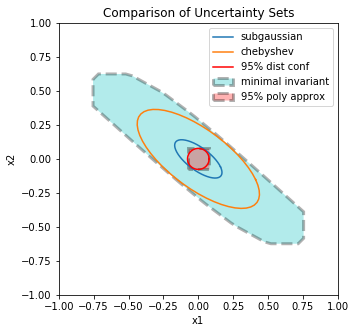

In [44]:
terminal_cov = controller.minimal_invariant_covariance / (t ** 2)
t_cheby = uncertainty_utils.calc_t_chebyshev(0.95, n)
plt.figure(figsize=(5,5))
ax = plt.gca()
terminal_set_boundary = uncertainty_utils.get_elipse(t, terminal_cov, np.zeros(n))
plt.plot(terminal_set_boundary[:,0], terminal_set_boundary[:,1])
terminal_set_boundary_cheby = uncertainty_utils.get_elipse(t_cheby, terminal_cov, np.zeros(n))
plt.plot(terminal_set_boundary_cheby[:,0], terminal_set_boundary_cheby[:,1])
plt.plot(disturbance_set[:,0], disturbance_set[:,1],"r")
M.plot(ax=ax, alpha=0.3, color="c")
disturbance_bound.plot(ax=ax, alpha=0.3, color="r")
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.legend(('subgaussian', 'chebyshev', '95% dist conf', 'minimal invariant', '95% poly approx'))
plt.title("Comparison of Uncertainty Sets")
plt.xlabel("x1")
plt.ylabel("x2")

## Test Trajectory Optimization with Sequential Convex Programming Solver

In [7]:
traj_opt = trajectory_optimizers.SCP_Traj_Opt(episode_length, Q, R, state_reference, np.zeros(m), state_constraints, input_constraints, tolerance=1e-9, regularization=1e0)
traj_opt.build()

In [8]:
As = [A_true for _ in range(episode_length)]
Bs = [B_true for _ in range(episode_length)]

for i in range(20):
    if i == 0:
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_init_traj.T, u_init_traj.T, As, Bs)
    else:
        x_traj_opt, u_traj_opt, converged = traj_opt.solve_iteration(x_traj.T, u_traj.T, As, Bs)
    
    controller = traj_opt.get_controller()
    x_traj, u_traj, _, _ = sim_traj(A_true, B_true, controller, x_init)
    if converged:
        break
print("converged in %d iterations" % traj_opt.i)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 4011.77it/s]


converged in 20 iterations


In [9]:
controller = controllers.LTI_MPC_Tracker(A_true, B_true, C_true,
                                         episode_length, 
                                         Q, R, state_reference, 
                                         state_constraints, input_constraints)
controller.build()
_ = controller.solve(x_init)
x_true_opt = controller.x_traj.value
u_true_opt = controller.u_traj.value
true_cost = controller.cost

In [10]:
print(np.linalg.norm(u_true_opt - traj_opt.input_traj_list[-1]))
print(np.linalg.norm(x_true_opt - traj_opt.traj_list[-1]))

1.0671262146267182e-05
8.780542088128855e-06


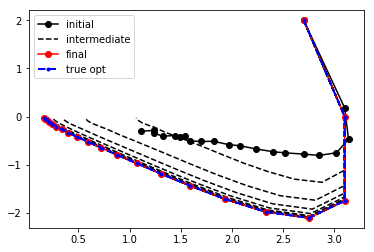

In [11]:
plt.plot(traj_opt.traj_list[0][0,:], traj_opt.traj_list[0][1,:], "k-o", label="initial")
for traj in traj_opt.traj_list[1:-1]:
    plt.plot(traj[0,:], traj[1,:], "k--", label="intermediate")
plt.plot(traj_opt.traj_list[-1][0,:], traj_opt.traj_list[-1][1,:], "r-o", label="final")
plt.plot(x_true_opt[0,:], x_true_opt[1,:], "b--.",label="true opt", lw=2)
ax = plt.gca()
h, l = ax.get_legend_handles_labels()
plt.legend([h[0], h[1], h[-2], h[-1]], [l[0], l[1], l[-2], l[-1]])

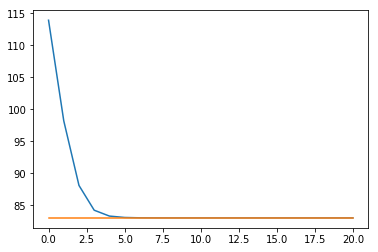

In [34]:
plt.plot(traj_opt.solution_costs)
plt.plot(np.arange(len(traj_opt.solution_costs)), np.ones(len(traj_opt.solution_costs)) * true_cost)

In [54]:
print(true_cost)

[83.01749 67.72749 55.07636 42.29818 30.30213 20.89383 14.1344   9.47226
  6.31766  4.20235  2.78998  1.84882  1.22216  0.80494  0.52697  0.34143
  0.21703  0.13279  0.07451  0.0325 ]


In [82]:
i = -1
traj_opt.traj_list[-1][:,i] - x_true_opt[:,i]

array([ 0.09608, -0.02468])